## Synthetic dataset generation -- Sequence based
**Author: Lin Lee Cheong <br>
Updated by: Tesfagabir Meharizghi<br>
Date created: 12/12/ 2020 <br>
Date updated: 02/18/2021 <br>**

Goal of this synthetic dataset is to create datasets to help understand how different relationships between tokens affect attention, SHAP and other interpretability factors.
- length of events (30, 300)
- spacing between 2+ coupled events, i.e. order of sequence matters
- amount of noise, i.e. performance vs interpretability
- vocabulary space

### Sequence dataset

Positive label is driven by a sequence of tokens
- Positive label probability is driven by the following formula
``` min(1.0, math.exp(-(a * ta)) + math.exp(-(h * th)) - math.exp(-(u * tu))) ```
Where:
- `a` is a constant related to `_A` events. It is the inverse of the contribution of `_A` events for positive label
- `h` is a constant related to `_H` events. It is the inverse of the contribution of `_H` events for positive label
- `u` is a constant related to `_U` events. It is the inverse of the contribution of `_U` events for positive label

- `ta` is the absolute position of the `_A` event in the sequence from the end.
- `th` is the absolute position of the `_H` event in the sequence from the end.
- `tu` is the absolute position of the `_U` event in the sequence from the end.

Note:
- All patients have one `_A`, one `_H` and one `_U` events each.
- since `_U` events have opposite effect to the adverse event, their contribution is subtracted.

In [2]:
import yaml
import string
import os
import numpy as np
import pandas as pd
import math
import random
import json

from utils import *

In [3]:
%load_ext autoreload

%autoreload 2

In [5]:
SEQ_LEN = 300

In [6]:
TOKEN_NAMES_FP = "./tokens_v2.yaml"

TRAIN_FP = "data/final_final/raw/{}/train.json".format(SEQ_LEN)
VAL_FP = "data/final_final/raw/{}/val.json".format(SEQ_LEN)
TEST_FP = "data/final_final/raw/{}/test.json".format(SEQ_LEN)

UID_COLNAME = "patient_id"

TRAIN_NROWS = 4000
VAL_NROWS = 2000
TEST_NROWS = 2000

UID_LEN = 10

# Total patients in the each split (will be balanced)
TOTAL_TRAIN = 18000
TOTAL_VAL = 6000
TOTAL_TEST = 6000

In [7]:
# Load tokens from yaml file path
tokens = load_tokens(TOKEN_NAMES_FP)
for key in tokens.keys():
    print(f"{key}: {len(tokens[key])} tokens")

adverse_tokens: 10 tokens
adverse_helper_tokens: 10 tokens
adverse_unhelper_tokens: 10 tokens
noise_tokens: 15 tokens


In [8]:
for key, tok in tokens.items():
    print(key)
    print(tok)
    print("-" * 50)

adverse_tokens
['Acute_Myocardial_Infarction_A', 'hypertension_A', 'arrhythmia_A', 'congestive_heart_failure_A', 'heart_valve_failure_A', 'pulmonary_embolism_A', 'ventricular_aneurysm_A', 'ventricular_hypertrophy_A', 'cardiomyopathy_A', 'Chronic_Obstructive_Pulmonary_Disease_A']
--------------------------------------------------
adverse_helper_tokens
['sleep_apnea_H', 'pneumonia_H', 'coronary_artery_disease_H', 'edema_H', 'troponin_H', 'Brain_Natriuretic_Peptide_H', 'alchoholism_H', 'metabolic_disorder_H', 'elevated_creatinine_H', 'electrolyte_imbalance_H']
--------------------------------------------------
adverse_unhelper_tokens
['Percutaneous_Coronary_Intervention_U', 'electrical_cardioversion_U', 'catheter_ablation_U', 'pacemaker_U', 'cardiac_rehab_U', 'sleep_apnea_treatment_U', 'ACE_inhibitors_U', 'ARB_U', 'diuretics_U', 'beta_blockers_U']
--------------------------------------------------
noise_tokens
['eye_exam_N', 'annual_physical_N', 'hay_fever_N', 'headache_N', 'foot_pain_N',

Total number of observations

* 90%
    * 2 adverse + 1 helper
* 80%
    * 1 adverse + 2 helper
* 70%
    * 1 adverse + 1 helper
* 40%
    * 1 helper + 1 unhelper
* 30%
    * 1 adverse + 2 unhelper
* 20%
    * 1 helper + 2 unhelper
* 10%
    * 2 unhelpers

In [9]:
TRAIN_COUNTS = 3000
VAL_COUNTS = 1000
TEST_COUNTS = 1000

TRAIN_COUNT_DICT = {
    "AAH": [0.9, TRAIN_COUNTS],
    "AHH": [0.8, TRAIN_COUNTS],
    "AH": [0.7, TRAIN_COUNTS],
    "HU": [0.4, TRAIN_COUNTS],
    "AUU": [0.3, TRAIN_COUNTS],
    "HUU": [0.2, TRAIN_COUNTS],
    "UU": [0.1, TRAIN_COUNTS],
}

VAL_COUNT_DICT = {
    "AAH": [0.9, VAL_COUNTS],
    "AHH": [0.8, VAL_COUNTS],
    "AH": [0.7, VAL_COUNTS],
    "HU": [0.4, VAL_COUNTS],
    "AUU": [0.3, VAL_COUNTS],
    "HUU": [0.2, VAL_COUNTS],
    "UU": [0.1, VAL_COUNTS],
}

TEST_COUNT_DICT = {
    "AAH": [0.9, TEST_COUNTS],
    "AHH": [0.8, TEST_COUNTS],
    "AH": [0.7, TEST_COUNTS],
    "HU": [0.4, TEST_COUNTS],
    "AUU": [0.3, TEST_COUNTS],
    "HUU": [0.2, TEST_COUNTS],
    "UU": [0.1, TEST_COUNTS],
}

In [10]:
# Mappings of the token groups with the abbreviation
TOKEN_MAPPINGS = {
    "A": "adverse_tokens",
    "H": "adverse_helper_tokens",
    "U": "adverse_unhelper_tokens",
}

In [187]:
#(a=0.2, h=0.4, u=0.75)
a = 0.2  # Constant for Adverse
h = 0.4  # Constant for helper
u = 0.75  # Constant for unhelper


In [188]:
math.exp(-(a)), math.exp(-(h)), math.exp(-(u))

(0.8187307530779818, 0.6703200460356393, 0.4723665527410147)

## added by Guang: generate probability and append label to each record by reading the json file instead of regenerating the file 

In [259]:
def get_proba(seq, base_seq_len=30):
    if base_seq_len == 30:
        multiplier = 0.5
    else:
        multiplier = 0.05
    prob = 0
    for ts in seq:
        event = seq[ts]
        if event.endswith('_A'): 
            prob += math.exp(-(a * int(ts) * multiplier)) 
        elif event.endswith('_H'):
            prob += math.exp(-(h * int(ts) * multiplier))
        elif event.endswith('_U'):
            prob -= math.exp(-(u * int(ts) * multiplier))
    prob = max(0.1,min(1, prob))
    return round(prob, 4)

def get_gap(seq, category, base_seq_len=30):
    if 'A' in category:
        min_ta = base_seq_len + 1
        min_thu = base_seq_len + 1
        for ts in seq:
            event = seq[ts]
            if event.endswith('_A'): 
                min_ta = min(min_ta,int(ts))
            else:
                min_thu = min(min_thu, int(ts))
        return (min_thu - min_ta)/min(min_ta,min_thu)
    elif 'H' in category:
        min_th = base_seq_len + 1
        min_tu = base_seq_len + 1
        for ts in seq:
            event = seq[ts]
            if event.endswith('_H'): 
                min_th = min(min_th,int(ts))
            else:
                min_tu = min(min_tu, int(ts))
        return (min_tu - min_th)/min(min_th,min_tu)
    else:
        return 0
                       
def append_label(seq_len,split='train'):
    label_dict = {} 
    prob_dict = {}

    with open('data/{}/{}.json'.format(seq_len, split)) as f:
        data = json.load(f)

    for category in data:
        for patient_seq in data[category]:
            prob  =  get_proba(patient_seq, seq_len)
            gap = get_gap(patient_seq, category)
            prob_dict.setdefault(category, []).append({gap:prob})
            label_dict.setdefault(category, []).append(get_label(prob, target=1))
    return label_dict, prob_dict        

In [260]:
label_train_30_seq, prob_train_30_seq = append_label(30, split='train')
label_val_30_seq, prob_val_30_seq = append_label(30, split='val')
label_test_30_seq, prob_test_30_seq = append_label(30, split='test')

In [261]:
label_train_300_seq, prob_train_300_seq = append_label(300, split='train')
label_val_300_seq, prob_val_300_seq = append_label(300, split='val')
label_test_300_seq, prob_test_300_seq = append_label(300, split='test')

# dump label to json


In [262]:
def dump_data_to_json(label, output_path):
    with open(output_path, "w") as fp:
        json.dump(label, fp, indent=4)

In [274]:
dump_data_to_json(label_train_30_seq, 'data/30/label_train.json')
dump_data_to_json(label_val_30_seq, 'data/30/label_val.json')
dump_data_to_json(label_test_30_seq, 'data/30/label_test.json')
dump_data_to_json(label_train_300_seq, 'data/300/label_train.json')
dump_data_to_json(label_val_300_seq, 'data/300/label_val.json')
dump_data_to_json(label_test_300_seq, 'data/300/label_test.json')

# QC and Visualization 

In [264]:
pd.DataFrame(label_train_30_seq).mean(),pd.DataFrame(label_val_30_seq).mean(),pd.DataFrame(label_test_30_seq).mean()

(AAH    0.884333
 AHH    0.797333
 AH     0.692000
 HU     0.202333
 AUU    0.274333
 HUU    0.171000
 UU     0.096667
 dtype: float64,
 AAH    0.893
 AHH    0.762
 AH     0.704
 HU     0.197
 AUU    0.299
 HUU    0.156
 UU     0.118
 dtype: float64,
 AAH    0.893
 AHH    0.795
 AH     0.705
 HU     0.218
 AUU    0.278
 HUU    0.167
 UU     0.109
 dtype: float64)

In [265]:
pd.DataFrame(label_train_300_seq).mean(),pd.DataFrame(label_val_300_seq).mean(),pd.DataFrame(label_test_300_seq).mean()

(AAH    0.911000
 AHH    0.846333
 AH     0.750333
 HU     0.226667
 AUU    0.238667
 HUU    0.170667
 UU     0.105667
 dtype: float64,
 AAH    0.927
 AHH    0.848
 AH     0.780
 HU     0.199
 AUU    0.223
 HUU    0.170
 UU     0.106
 dtype: float64,
 AAH    0.925
 AHH    0.830
 AH     0.759
 HU     0.238
 AUU    0.247
 HUU    0.177
 UU     0.100
 dtype: float64)

In [266]:
def convert_prob_dict_to_df(prob_dict):
    rows = [] 
    # appending rows 
    for category in prob_dict: 
        row = {}
        row['group'] = category
        for record in prob_dict[category]:
            for gap in record:
                row['time_gap'] = gap
                row['prob'] = record[gap]
                rows.append(row.copy()) 
    # using data frame 
    prob_df = pd.DataFrame(rows) 
    return prob_df

In [269]:
prob_train_30_seq_df = convert_prob_dict_to_df(prob_train_30_seq)
prob_train_300_seq_df = convert_prob_dict_to_df(prob_train_300_seq)

In [245]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 5, 'figure.figsize':(20,12)})
sns.set_style('ticks')

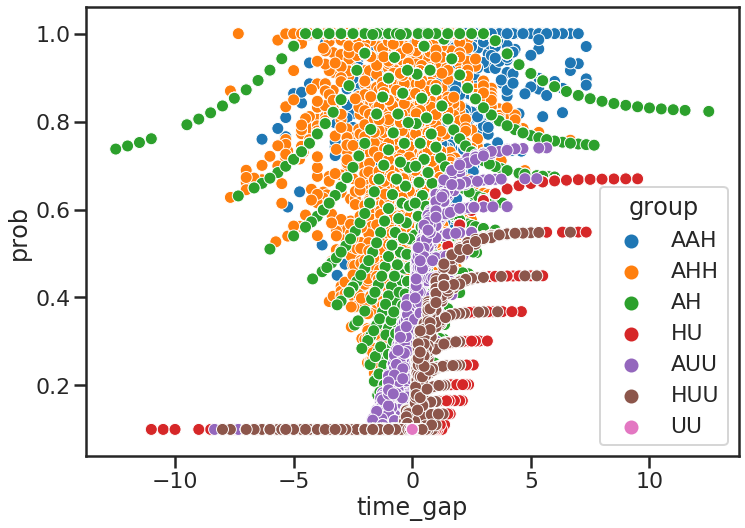

In [270]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(data=prob_train_30_seq_df, x="time_gap", y="prob", hue="group")

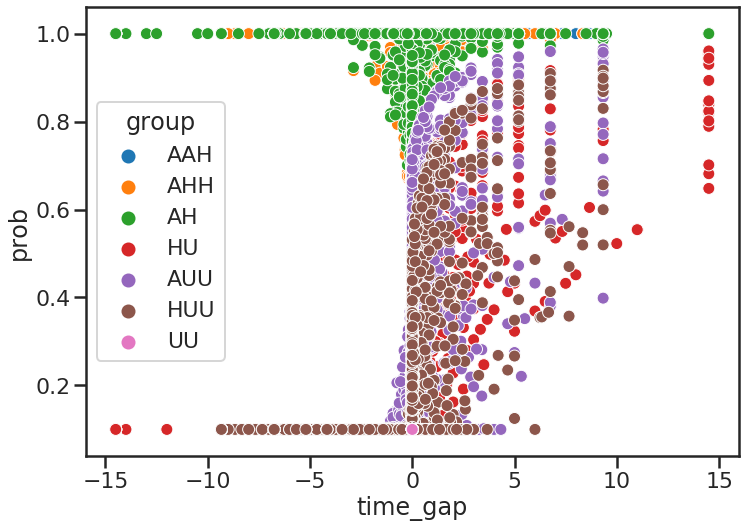

In [271]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(data=prob_train_300_seq_df, x="time_gap", y="prob", hue="group")

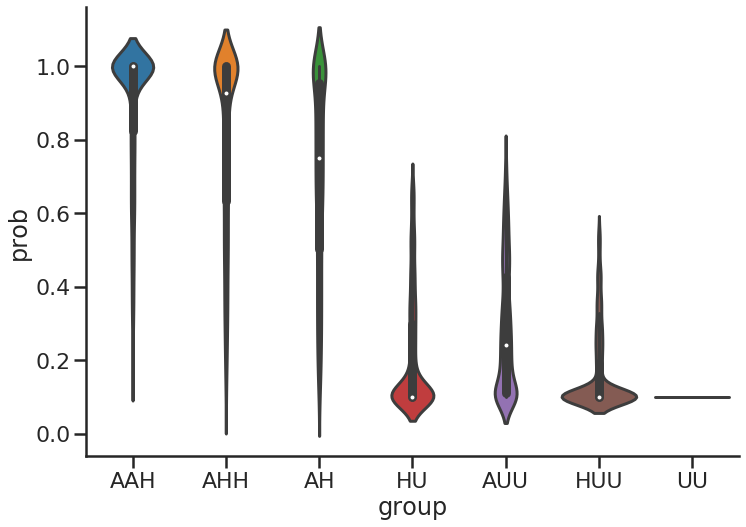

In [272]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.violinplot(x="group", y="prob", data=prob_train_30_seq_df)
sns.despine()

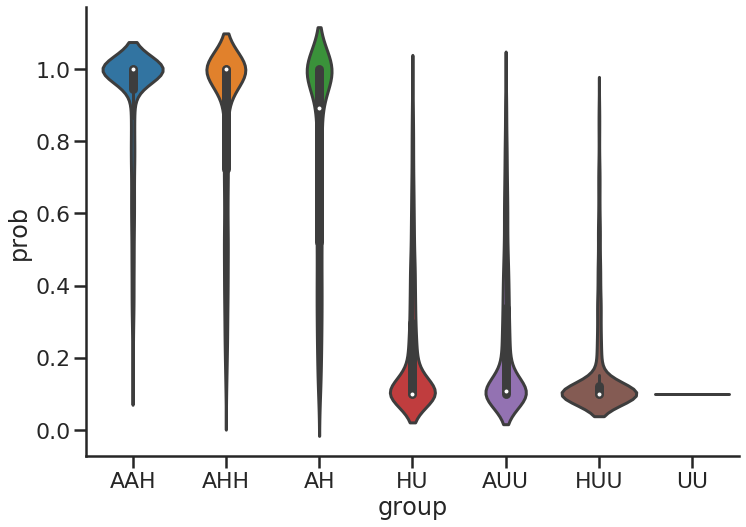

In [273]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.violinplot(x="group", y="prob", data=prob_train_300_seq_df)
sns.despine()

In [72]:
with open('data/30/train.json') as f:
    train_data = json.load(f)


In [204]:
train_data['AAH'][2], get_proba(train_data['AAH'][2]), get_gap(train_data['AAH'][2], 'AAH')

({'6': 'ventricular_aneurysm_A',
  '13': 'Brain_Natriuretic_Peptide_H',
  '16': 'Chronic_Obstructive_Pulmonary_Disease_A'},
 0.825,
 1.1666666666666667)

In [205]:
train_data['AAH'][1], get_proba(train_data['AAH'][1]), get_gap(train_data['AAH'][1], 'AAH')

({'3': 'electrolyte_imbalance_H',
  '6': 'congestive_heart_failure_A',
  '7': 'ventricular_hypertrophy_A'},
 1,
 -1.0)

In [206]:
train_data['AAH'][3], get_proba(train_data['AAH'][3]), get_gap(train_data['AAH'][3], 'AAH')

({'22': 'coronary_artery_disease_H',
  '24': 'hypertension_A',
  '25': 'ventricular_aneurysm_A'},
 0.1851,
 -0.09090909090909091)

In [208]:
train_data['AAH'][5], get_proba(train_data['AAH'][5]), get_gap(train_data['AAH'][5], 'AAH')

({'4': 'troponin_H',
  '5': 'Acute_Myocardial_Infarction_A',
  '7': 'Acute_Myocardial_Infarction_A'},
 1,
 -0.25)

# code to generate the dummy patient data 

In [27]:
def downsample(df0, label, total):
    """Downsample the dataset to make it balanced class."""
    df = df0.copy()
    df_c0 = df[df[label] == 0]
    df_c1 = df[df[label] == 1]

    df_c0 = df_c0.sample(int(total / 2))
    df_c1 = df_c1.sample(int(total / 2))

    df = pd.concat([df_c0, df_c1], axis=0)
    df = df.sample(frac=1)
    return df


def get_proba(seq, base_seq_len=30):
    """Get probability of being positive label for a sequence."""

    def get_position(seq, substring, base_seq_len):
        """Get position of event with substring from end of sequence"""
        pos = -1
        for i, event in enumerate(seq):
            if event.endswith(substring):
                pos = i
                break
        if pos == -1:
            raise ValueError(f"Error! {substring} not found!")

        pos = len(seq) - pos - 1
        return pos

    seq_len = len(seq)
    multiplier = float(base_seq_len) / seq_len
    ta = get_position(seq, "_A", base_seq_len) * multiplier
    th = get_position(seq, "_H", base_seq_len) * multiplier
    tu = get_position(seq, "_U", base_seq_len) * multiplier

    prob = min(1.0, math.exp(-(a * ta)) + math.exp(-(h * th)) - math.exp(-(u * tu)))
    prob = round(prob, 4)
    return prob


def get_a_sequence_seq_v2(seq_len, label, tokens, token_mappings, seq_tokens, proba):
    """creates sequence + label (at the end of list) with specific orderings.
    returns list of list"""
    n_seq_tokens = len(seq_tokens)
    n_noise = (
        np.max(
            (
                10,
                random.choices(range(n_seq_tokens, seq_len), k=1)[0],
            )
        )
        - (n_seq_tokens)
    )
    sel_positions = sorted(random.sample(range(n_noise), k=n_seq_tokens))
    sel_tokens = []
    for key in seq_tokens:
        key_mapping = token_mappings[key]
        sel_tokens.append(random.choices(tokens[key_mapping])[0])

    # Randomize sequence
    random.shuffle(sel_tokens)

    sel_tokens = list(zip(sel_positions, sel_tokens))
    sel_noise = get_tokens(seq_len, tokens, "noise_tokens", n_noise)

    for idx, event in sel_tokens:
        sel_noise.insert(idx, event)

    sel_noise = ["<pad>"] * (seq_len - len(sel_noise)) + sel_noise

    # Get probability of being positive label
    # sel_noise.reverse()
    sim_lab = get_label(proba, target=label)

    sequence = sel_noise + [proba] + [sim_lab]

    return sequence


def get_sequences_v2(
    seq_len,
    label,
    uid_len,
    uid_colname,
    tokens,
    token_mappings,
    seq_tokens,
    n_seq,
    proba,
):
    """Get multiple sequences."""

    sequences = [
        get_a_sequence_seq_v2(seq_len, label, tokens, token_mappings, seq_tokens, proba)
        + [get_uid(uid_len)]
        for _ in range(n_seq)
    ]
    # print(f"seq based events generated")

    seq_df = pd.DataFrame(sequences)
    seq_df.columns = [str(x) for x in range(seq_len - 1, -1, -1)] + [
        "proba",
        "label",
        uid_colname,
    ]

    return seq_df


def get_sequence_dataset(
    seq_len, uid_len, uid_colname, count_dict, tokens, token_mappings, total_rows
):
    """Generate a simple toy dataset.

    Arg:
    -----
        seq_len (int) : length of the generated sequence
        uid_len (int) : length of uid token
        uid_colname (str) : name of uid column, usually patient_id
        count_dict (dict) : dictionary of various sequence types.
            6 different types are allowed:
                n_ppp_adverse, n_pp_adverse, n_p_adverse
                n_nnn_adverse, n_nn_adverse, n_n_adverse
        tokens (dict) : dictionary of the various token types

    Returns:
    --------
        dataset (dataframe) : dataframe containing all the
                              generated dataset, randomly mixed

    """
    label = 1
    cat_lst = []
    for seq_tokens, (proba, n_seq) in count_dict.items():
        df = get_sequences_v2(
            seq_len,
            label,
            uid_len,
            uid_colname,
            tokens,
            token_mappings,
            seq_tokens,
            n_seq,
            proba,
        )

        df["seq_event"] = seq_tokens
        cat_lst.append(df.copy())
    dataset = pd.concat(cat_lst, axis=0)
    dataset.reset_index(inplace=True)
    indexes = [idx for idx in range(dataset.shape[0])]
    random.shuffle(indexes)
    dataset = dataset.iloc[indexes, :]
    # dataset = dataset.sample(frac=1).reset_index(drop=True)

    # dataset = downsample(dataset, "label", total_rows)
    print(f"dataset: {dataset.shape}")
    print(f"ratio:\n{dataset.label.value_counts(normalize=True)}\n")

    return dataset

In [28]:
print(f"Train Data Imbalance for seq_len={SEQ_LEN}...")
df_train = get_sequence_dataset(
    seq_len=SEQ_LEN,
    uid_len=UID_LEN,
    uid_colname=UID_COLNAME,
    count_dict=TRAIN_COUNT_DICT,
    tokens=tokens,
    token_mappings=TOKEN_MAPPINGS,
    total_rows=TRAIN_COUNTS,
)

print(f"Val Data Imbalance for seq_len={SEQ_LEN}...")
df_val = get_sequence_dataset(
    seq_len=SEQ_LEN,
    uid_len=UID_LEN,
    uid_colname=UID_COLNAME,
    count_dict=VAL_COUNT_DICT,
    tokens=tokens,
    token_mappings=TOKEN_MAPPINGS,
    total_rows=VAL_COUNTS,
)

print(f"Test Data Imbalance for seq_len={SEQ_LEN}...")
df_test = get_sequence_dataset(
    seq_len=SEQ_LEN,
    uid_len=UID_LEN,
    uid_colname=UID_COLNAME,
    count_dict=TEST_COUNT_DICT,
    tokens=tokens,
    token_mappings=TOKEN_MAPPINGS,
    total_rows=TEST_COUNTS,
)

Train Data Imbalance for seq_len=300...
dataset: (21000, 305)
ratio:
0    0.516381
1    0.483619
Name: label, dtype: float64

Val Data Imbalance for seq_len=300...
dataset: (7000, 305)
ratio:
0    0.508429
1    0.491571
Name: label, dtype: float64

Test Data Imbalance for seq_len=300...
dataset: (7000, 305)
ratio:
0    0.521143
1    0.478857
Name: label, dtype: float64



In [29]:
print(df_train.shape)
# df_train.sort_values("proba")[::-1]
df_train.head()

(21000, 305)


,index,299,298,297,296,295,294,293,292,291,...,5,4,3,2,1,0,proba,label,patient_id,seq_event
4256,1256,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,quad_injury_N,eye_exam_N,cut_finger_N,ingrown_nail_N,dental_exam_N,ingrown_nail_N,0.8,1,ZTKBJ30YFM,AHH
14612,2612,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ankle_sprain_N,backache_N,foot_pain_N,headache_N,foot_pain_N,peanut_allergy_N,0.3,0,HIUSSBYZAB,AUU
13098,1098,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,dental_exam_N,pacemaker_U,hay_fever_N,headache_N,cold_sore_N,dental_exam_N,0.3,0,348J3FNVNH,AUU
8562,2562,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,eye_exam_N,...,ingrown_nail_N,hay_fever_N,ankle_sprain_N,ACL_tear_N,ACL_tear_N,ingrown_nail_N,0.7,1,PJ342UBGHK,AH
9745,745,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,backache_N,annual_physical_N,foot_pain_N,ACL_tear_N,cold_sore_N,eye_exam_N,0.4,0,E4AGUBC3FE,HU


In [30]:
df_val.shape

(7000, 305)

In [31]:
df_test.shape

(7000, 305)

In [32]:
def process(df0, count_dict, seq_len, output_path):
    """Process data and converting to list of dicts."""
    print("Processing data...")
    feature_names = [str(i) for i in range(seq_len - 1, -1, -1)]

    data = {}
    for category, values in count_dict.items():
        data[category] = []
        df = df0[df0["seq_event"] == category]
        df = df[feature_names]
        n_rows = df.shape[0]
        for idx in range(n_rows):
            row = df.iloc[idx].tolist()
            row.reverse()
            row = dict(zip(range(SEQ_LEN), row))
            row2 = row.copy()
            for key, value in row.items():
                if value.endswith("_N") or value == "<pad>":
                    del row2[key]
            data[category].append(row2.copy())

    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    with open(output_path, "w") as fp:
        json.dump(data, fp, indent=4)
    print("SUCCESS!")

In [33]:
process(df_train, TRAIN_COUNT_DICT, SEQ_LEN, TRAIN_FP)
process(df_val, VAL_COUNT_DICT, SEQ_LEN, VAL_FP)
process(df_test, TEST_COUNT_DICT, SEQ_LEN, TEST_FP)

Processing data...
SUCCESS!
Processing data...
SUCCESS!
Processing data...
SUCCESS!


In [34]:
# save_csv(df_train, TRAIN_FP)
# save_csv(df_val, VAL_FP)
# save_csv(df_test, TEST_FP)

In [35]:
# df = pd.read_csv(TRAIN_FP)
# print(df.shape)
# df.head()

In [36]:
# df.label.value_counts(normalize=True)